In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.model_selection import KFold
import os.path
import shutil
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

### Input variables 

In [2]:
inputfile = 'Elisa dataset.xlsx'
# Evaluation params
val_rounds = 100
xFold = 10

### Defining functions

Functions used to fit a sigmoidal curve to the dataset and to extrapolate x (titer) for a given y (absorbance)

In [3]:
# Sigmoidal function
def sigmoid_log_concentration(x, ymin, ymax, ec50, hill):
    y = ymin + (ymax - ymin) / (1 + 10 ** ((np.log10(np.abs(ec50)) - x) * hill))
    return y

# Log function
def log_function(x, a, b):
    y = a + b * np.log10(x)
    return y

# Infer x for a given y
def resolve_x(y, ymin, ymax, ec50, hill):
    x = np.log10(np.abs(ec50)) -  np.log10(np.abs((ymax - ymin)/(y - ymin) - 1))/hill  
    return x

def fit_function_to_data(function, titer_train, abs_train):
#     popt, pcov = fit_function_to_data(sigmoid_log_concentration, titer_train, abs_train)
    popt, pcov = curve_fit(sigmoid_log_concentration, titer_train, abs_train, maxfev=100000)
    return(popt)

Functions for cross-validation

In [4]:
def Define_sets(patient_ar, titer_ar, abs_ar, train_index, test_index):
    patient_train, patient_test = [], []
    titer_train, titer_test = [], []
    abs_train, abs_test = [], []
    abs_model = []
    for i in train_index:
        patient_train.append(patient_ar[i])
        titer_train.append(titer_ar[i])
        abs_train.append(abs_ar[i])
    for i in test_index:
        patient_test.append(patient_ar[i])
        titer_test.append(titer_ar[i])
        abs_test.append(abs_ar[i])
    return(patient_train, patient_test, titer_train, titer_test, abs_train, abs_test, abs_model)

def Add_predicted_to_df(patient_test, abs_test, min_titer, max_titer, df, ymin, ymax, ec50, hill):
    for i in range(0, len(patient_test)):
        patient = patient_test[i]
        abs_2_predict = abs_test[i]
        pred_titer = resolve_x(abs_2_predict, ymin, ymax, ec50, hill)
        if pred_titer < min_titer:
            pred_titer = min_titer
        if pred_titer > max_titer:
            pred_titer = max_titer
        df.loc[patient,('Pred_Log10_Titer')] = pred_titer
    return(df)

def extract_obs_pred(df):
    df.dropna(axis=0, how='any', inplace=True)
    x_obs = np.array(df.loc[:,])
    x_obs = np.array(df.loc[:,'Log10_Titer'])
    x_pred = np.array(df.loc[:,'Pred_Log10_Titer'])
    return(x_obs, x_pred)

def evaluate_prediction(obs, pred):
    r2 = r2_score(obs, pred)
    rmse = np.sqrt(mean_squared_error(obs, pred))
    return(r2, rmse)

### Load data 

Load the input excel file and transform it such that titers are log10. The processed input is saved as a separate excel spreadsheet

In [5]:
df0 = pd.read_excel(inputfile, index_col=0, header=0)
# Excluding samples that have a titer of 0
df1 = df0[df0.Titer != 0].copy()

for indx in df1.index:
    logval = np.log10(df1.loc[indx, ('Titer')])
    df1.at[indx, 'Log10_Titer'] = logval
outputfile = inputfile.replace('.xlsx','_processed.xlsx')
df1.to_excel(outputfile)

### Extract info from input dataset

Extracts the sample names, titers (log10), absorbances, the minimum observed titer and maximum observed titer

In [6]:
patient_ar=df1.index.tolist()
titer_ar = np.array(df1.loc[:,'Log10_Titer'].values)
abs_ar0 = np.array(df1.loc[:,'Absorbance'].values)
min_titer = titer_ar.min()
max_titer = titer_ar.max()
print('Number of patients:', len(patient_ar))
print('Number of titers:', len(titer_ar))
print('Minimum titer', min_titer)
print('Maximum titer', max_titer)
print('Number of Absorbances:', len(abs_ar0))

Number of patients: 229
Number of titers: 229
Minimum titer 1.954242509439325
Maximum titer 5.771210340746464
Number of Absorbances: 229


### Fit sigmoid model to data 

Fits a sigmoidal to the entire dataset and saves the model info in a separate file that is to be used by 'titer_extrapol.ipynb' to predict titers for a given absorbance

In [7]:
opt_all = fit_function_to_data(sigmoid_log_concentration, titer_ar, abs_ar0)
model_file = inputfile.replace('.xlsx', '_model.txt')
f = open(model_file, 'w')
print('model_ymin', opt_all[0], sep='\t', file=f)
print('model_ymax', opt_all[1], sep='\t', file=f)
print('model_ec50', opt_all[2], sep='\t', file=f)
print('model_hill', opt_all[3], sep='\t', file=f)
print('obs_titer_min', min_titer, sep='\t', file=f)
print('obs_titer_max', max_titer, sep='\t', file=f)
f.close()

### Evaluating model fitting by X-fold cross-validation

In [8]:
# Creating/Cleaning evaluation directory
outdir = 'eval_' + str(val_rounds) + 'iter_' + str(xFold) + 'fold'
if os.path.isdir(outdir):
    shutil.rmtree(outdir)
os.mkdir(outdir)

In [9]:
%%capture
# Running X-val iteratively
df_eval = pd.DataFrame(columns = ['Iteration','R2','RMSE'])
eval_mode = str(xFold) + '-fold'
abs_ar = abs_ar0.copy()
for i in range(0,val_rounds):
    plt.figure(figsize=(10,10))
    if i%5 == 0:
        print('Round\t{}'.format(i))
    df2 = df1.copy()
    kf = KFold(n_splits=xFold, shuffle=True)
    x_fold = 0
    for train_index, test_index in kf.split(patient_ar):
        patient_train, patient_test, titer_train, titer_test, abs_train, abs_test, abs_model = Define_sets(patient_ar, titer_ar, abs_ar, train_index, test_index)
        min_titer_local = np.min(titer_train)
        max_titer_local = np.max(titer_train)
        popt = fit_function_to_data(sigmoid_log_concentration, titer_train, abs_train)
        df2 = Add_predicted_to_df(patient_test, abs_test, min_titer_local, max_titer_local, df2,*popt)
    x_obs, x_pred = extract_obs_pred(df2)
    r2, rmse = evaluate_prediction(x_obs, x_pred)
    dftemp = pd.DataFrame({'Iteration':[i],'R2':[r2],'RMSE':[rmse]})
    df_eval = df_eval.append(dftemp, ignore_index=True)
    df2.to_excel(outdir + '/' + 'iter_' + str(i) + '_' + eval_mode + '_predictions.xlsx')
    g=sns.lmplot(x='Log10_Titer', y="Pred_Log10_Titer", data=df2, height=8, x_jitter=.0, ci=95, scatter_kws={"s": 100})
    plt.suptitle('Observed Vs Predicted: Iteration ' + str(i) + ' (' + eval_mode + ')', fontsize=15)
    plt.xlabel('Observed Log10 Ab titers', fontsize=15)
    plt.ylabel('Predicted Log10 Ab titers', fontsize=15)
    plt.text(5, 4, 'R^2: {:.2f}'.format(r2), fontsize=10)
    plt.savefig(outdir + '/' + 'iter_' + str(i) + '_' + eval_mode + '_Observed_Vs_Predicted.pdf',dpi=300)
df_eval.to_excel(outdir + '/' + 'summary.xlsx')

<Figure size 720x720 with 0 Axes>

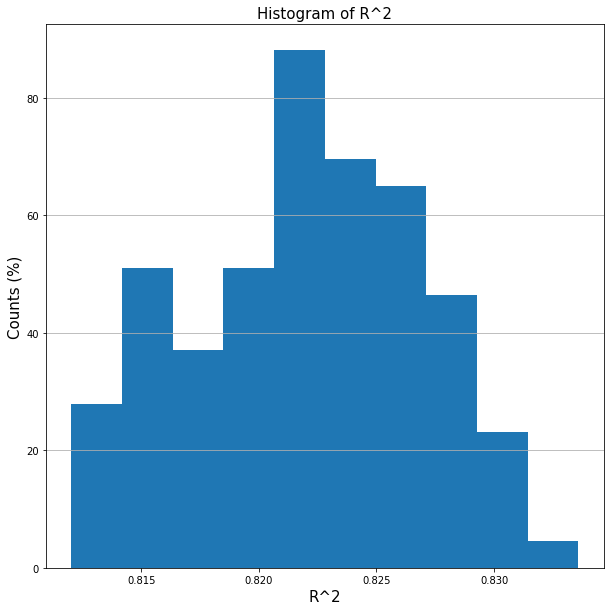

In [30]:
# Plot histogram of R^2
plt.figure(figsize=(10,10))
ar = df_eval['R2'].to_numpy()
plt.figure(figsize=(10,10))
plt.hist(ar, density=True)
plt.xlabel('R^2', fontsize=15)
plt.ylabel('Counts (%)', fontsize=15)
plt.title('Histogram of R^2', fontsize=15)
plt.grid(axis='y')
plt.savefig(outdir + '/histogram.pdf',dpi=300)